# CS:GO Classification

In [ ]:
pip install nevergrad

     |████████████████████████████████| 411 kB 7.2 MB/s 
     |████████████████████████████████| 269 kB 52.0 MB/s 
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=27958fafb5d18d3168bfaf35a852ca71ef903fc7173a499b50641c62f240afad
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
pip install lightgbm

In [ ]:
pip install xgboost

In [ ]:
pip install seaborn

# EDA

En primer lugar, se deben importar los ficheros csv de train y de test.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.compose
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import f1_score, accuracy_score
import nevergrad as ng
import xgboost as xgb

from sklearn.metrics import ConfusionMatrixDisplay


train_data = pd.read_csv('https://raw.githubusercontent.com/amsanabria/ClasificacionML/45d0a145115e6c9a300db738624b85cf81787ac9/train.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/amsanabria/ClasificacionML/45d0a145115e6c9a300db738624b85cf81787ac9/test.csv')

train_data.describe(include='all')

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,...,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner,round_winner.1
count,73446.000000,73446.000000,73446.000000,73446,73446,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.00000,73446.000000,73446.0,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.0,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.0,73446.000000,73446.000000,...,73446.0,73446.000000,73446.0,73446.000000,73446.000000,73446.0,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446,73446
unique,NaN,NaN,NaN,8,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,NaN,NaN,NaN,de_inferno,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T,T
freq,NaN,NaN,NaN,14257,65203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37444,37444
mean,97.879891,6.700324,6.776720,NaN,NaN,411.646883,402.341339,314.032337,298.506849,9726.591646,11204.361708,2.044822,2.771805,1.604757,4.269150,4.262696,0.274093,1.244670,0.135855,0.007570,0.57095,0.321079,0.0,0.000123,0.150723,0.106895,0.004044,0.001675,0.110503,0.004847,0.0,0.000803,0.010756,0.109169,0.006685,3.305177,0.000014,0.0,0.063325,0.002723,...,0.0,0.000054,0.0,0.000136,0.000749,0.0,0.236473,0.822591,0.060085,0.020968,0.046647,0.035822,0.007557,0.000313,0.442025,0.381028,0.061433,0.009585,3.177328,0.121600,0.234989,0.292215,0.174536,0.005147,0.008033,0.028565,0.895529,0.437001,1.847153,1.860469,1.537116,1.622580,0.997481,0.020015,0.047600,1.352817,0.027966,0.025257,NaN,NaN
std,54.483397,4.798172,4.825463,NaN,NaN,13

Antes de trabajar con los datos, se ha de saber si estamos trabajando con un conjunto de datos **desbalanceado** o no para ver si es necesario aplicar alguna técnica de **oversampling** o **undersampling**.

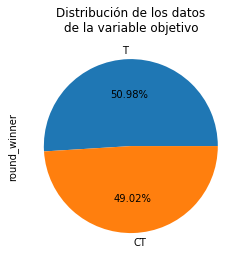

In [ ]:
train_data['round_winner'].value_counts().plot(kind='pie', autopct='%1.2f%%', title="Distribución de los datos\nde la variable objetivo")

Como se puede observar en el gráfico, el conjunto de datos está bastante balanceado por lo que no será necesaria ninguna transformación de las mencionadas previamente.

A continuación, vamos a estudiar las variables que tiene el conjunto de train. Cabe destacar, que tenemos dos tipos de variables:
* Numéricas: score, health, armor...
* Categóricas: map, bomb_planted y round_winner (variable objetivo)

Para una primera aproximación, vamos a hacer un histograma por cada variable:

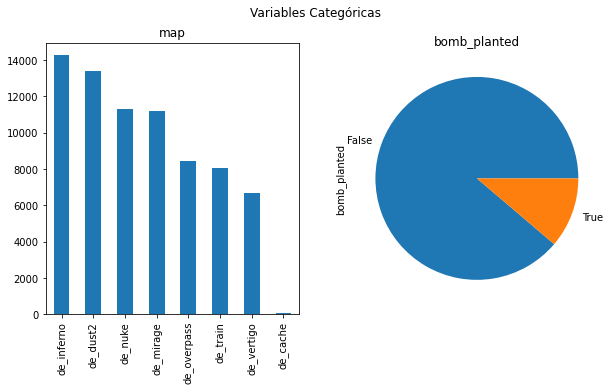

In [ ]:
fig, axs = plt.subplots(1,2)
fig.suptitle('Variables Categóricas')

train_data['map'].value_counts().plot(kind='bar', ax = axs[0], title = 'map', figsize=[10,5])
train_data['bomb_planted'].value_counts().plot(kind='pie', ax = axs[1], title = 'bomb_planted', figsize = [10,5])

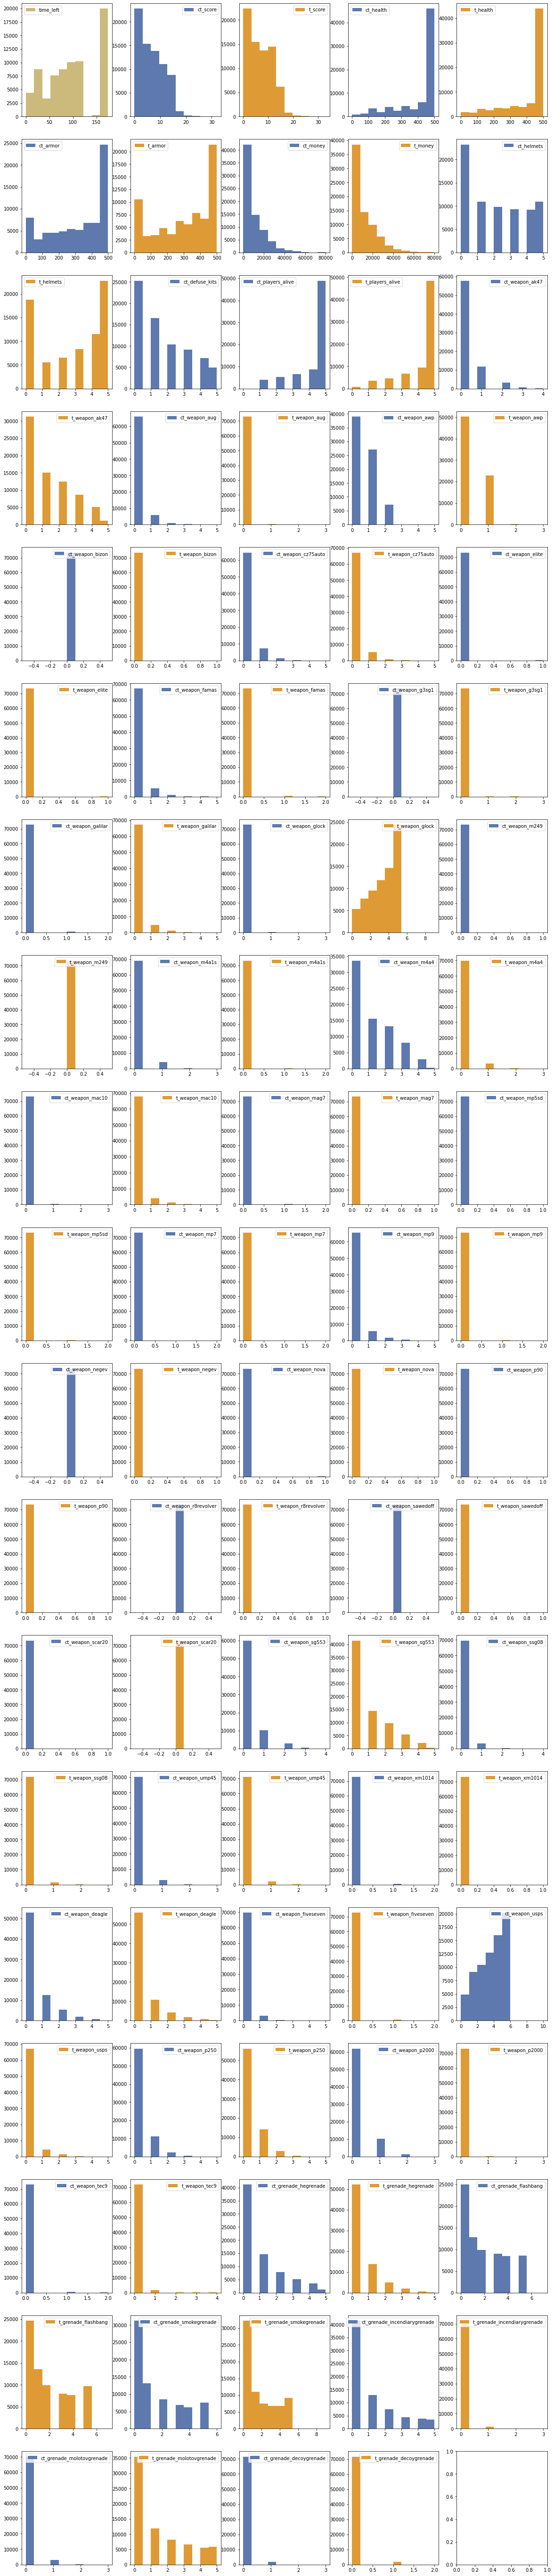

In [ ]:

fig, axes = plt.subplots(nrows = 19, ncols =5, figsize = (20, 100))
colors = ["#5d79ae", "#de9b35", "#ccba7c"] # 0 -> CT, 1 -> T, 2 -> Otros

for index,column in enumerate(train_data.select_dtypes(include=np.number)):
    ax = axes.flatten()[index]
    if 'ct_' in column:
        c = colors[0]
    elif 't_' in column:
        c = colors[1]
    else:
        c = colors[2]
    ax.hist(train_data[column], color = c, label = column)
    ax.legend(loc = "best")
plt.show()

Podemos observar varios detalles como que hay algunas instantáneas en las que el tiempo es mayor al tiempo máximo de la ronda, esto se debe a que se ha considerado que el tiempo máximo es: tiempo de la ronda + tiempo de compra + tiempo de la bomba = 115 + 20 + 40 = 175.

Además, también se puede observar como muchas columnas toman en casi todas las instantáneas un valor de 0.


Sin embargo, antes de empezar con el preprocesamiento y después de haber visto cómo se distribuyen los datos, nos podemos plantear si hay alguna variable de CS:GO que otorgue ventaja a alguno de los dos bandos según su valor. 

Para ello, podemos estudiar los mapas:

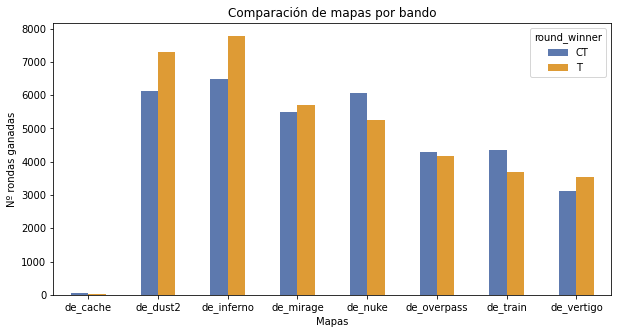

In [ ]:
csgo_colors = ["#5d79ae", "#de9b35"] # 0 -> CT, 1 -> T

maps = train_data.groupby('round_winner')['map'].value_counts(sort='True')
maps_side = maps.unstack().transpose()

maps_side.plot(kind='bar', color = csgo_colors,
               figsize = [10,5], rot = 0, 
               xlabel = 'Mapas', ylabel = 'Nº rondas ganadas', 
               title='Comparación de mapas por bando')

Como se puede observar, los dos mapas que más se juegan ('dust2' e 'inferno') parece que favorecen más al lado 'T', mientras que otros como 'nuke' favorecen más al bando 'CT'. El resto de mapas están bastante parejos.

Otro aspecto importante a estudiar, es qué ocurre cuando se ha plantado la bomba. En estos casos, como se puede observar en el siguiente gráfico, si se planta la bomba, en la mayoría de las veces gana el bando 'T'. Por otra parte, cuando no se planta la bomba, suele ganar 'CT' pero no hay una diferencia tan grande.

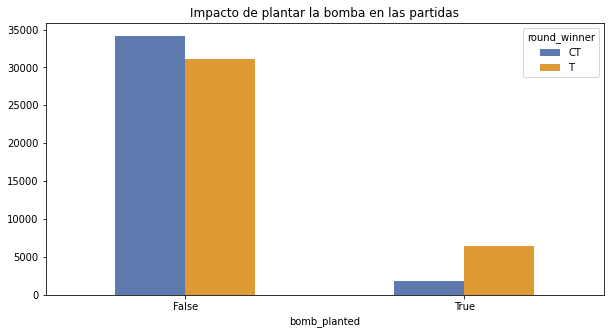

In [ ]:
csgo_colors = ["#5d79ae", "#de9b35"]

bomb_planted = train_data.groupby('round_winner')['bomb_planted'].value_counts(sort='True')
bomb_planted = bomb_planted.unstack().transpose()

bomb_planted.plot(kind='bar', color = csgo_colors,
                figsize = [10,5], rot = 0, 
                title="Impacto de plantar la bomba en las partidas")

# Data Preprocessing

Como se ha podido observar en los histogramas de las variables numéricas, hay algunas variables que toman valor 0 en todas las filas y otras que tienen una situación similar salvo por algunos datos puntuales.

A continuación, se procede a eliminar estos datos. Para determinar aquellas columnas numéricas a eliminar, se ha establecido como criterio aquellas en cuya media y desviación estándar sea menor a 0.05 ya que se considera que el impacto que tienen en la clasificación será prácticamente nulo.

In [ ]:
X = train_data.iloc[0:,0:-2]
y = train_data.iloc[0:,-2]

In [ ]:
def drop_low_mean_std_columns(dataframe):
    for c in dataframe.select_dtypes(include=np.number).columns:
        if dataframe[c].mean() < 0.05 and dataframe[c].std() < 0.05:
            print(c,"\t\tMedia:", dataframe[c].mean(),"\t\tDesviacion:", dataframe[c].std())
            dataframe.drop(columns=c,axis=1, inplace=True)

## Transformers

In [ ]:
drop_low_mean_std_columns(X)

column_transformer = sklearn.compose.ColumnTransformer(transformers=[
    ("map", OrdinalEncoder(), [3]),
    ("bomb_planted", OneHotEncoder(drop="first") , [4]),
    ("ct_players_alive", KBinsDiscretizer(n_bins=3),[14]),
    ("t_players_alive",KBinsDiscretizer(n_bins=3),[15])
], remainder='passthrough')
sc = StandardScaler()

X = column_transformer.fit_transform(X)
X = sc.fit_transform(X)
X

ct_weapon_bizon 		Media: 0.0 		Desviacion: 0.0
t_weapon_bizon 		Media: 0.00012253900825095988 		Desviacion: 0.011069130981414573
t_weapon_elite 		Media: 0.0016746997794297852 		Desviacion: 0.04088909297095301
ct_weapon_g3sg1 		Media: 0.0 		Desviacion: 0.0
t_weapon_g3sg1 		Media: 0.0008033112763118482 		Desviacion: 0.03780206224976603
ct_weapon_m249 		Media: 1.3615445361217766e-05 		Desviacion: 0.0036899112944929037
t_weapon_m249 		Media: 0.0 		Desviacion: 0.0
t_weapon_mag7 		Media: 5.4461781444871064e-05 		Desviacion: 0.0073796718660329354
ct_weapon_mp5sd 		Media: 0.0014704680990115188 		Desviacion: 0.03831873972995111
ct_weapon_mp7 		Media: 0.002137624921711189 		Desviacion: 0.04677122028853203
t_weapon_mp7 		Media: 0.0017836233423195273 		Desviacion: 0.042517026394380104
ct_weapon_negev 		Media: 0.0 		Desviacion: 0.0
t_weapon_negev 		Media: 1.3615445361217766e-05 		Desviacion: 0.003689911294494007
ct_weapon_nova 		Media: 0.0009939275113688968 		Desviacion: 0.03151115895945726
t_weapo

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


array([[ 1.80691969, -0.3555567 ,  0.        , ..., -0.81225619,
        -0.16396799, -0.15531685],
       [ 1.28880869, -0.3555567 ,  0.        , ..., -0.81225619,
        -0.16396799, -0.15531685],
       [ 1.28880869,  2.81249099,  0.        , ..., -0.81225619,
        -0.16396799, -0.15531685],
       ...,
       [ 0.2525867 , -0.3555567 ,  0.        , ...,  2.18983563,
        -0.16396799, -0.15531685],
       [-0.2655243 , -0.3555567 ,  0.        , ..., -0.81225619,
        -0.16396799, -0.15531685],
       [ 1.28880869, -0.3555567 ,  0.        , ...,  0.38858054,
        -0.16396799, -0.15531685]])

# Model training and evaluation

En este apartado, se van a probar varios modelos de clasificación, entre ellos algunos ensemble como XGBoost o Random Forest, y otros algoritmos como KNN o Nearest Centroid.

Previamente, se van a dividir los datos de entrenamiento para reducir el overfitting y se va a definir una función que devuelve los valores de las métricas de *accuracy* y *f1*.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Devuelve el valor de las métricas accuracy y F1 como una lista
def evaluate_metrics(predicted_y,y):
    ac = accuracy_score(y, predicted_y)
    f1 = f1_score(y, predicted_y, average='weighted')
    return { "Accuracy":ac, "F1":f1 }

## Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42,max_depth=200,n_estimators=200, n_jobs=-1)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)

print(rf)
rf_metrics = evaluate_metrics(rf_pred,y_val)
print(rf_metrics)

RandomForestClassifier(max_depth=200, n_estimators=200, n_jobs=-1,
                       random_state=42)
{'Accuracy': 0.8401683307203565, 'F1': 0.8401755088835812}


## Gradient Boosting

In [ ]:
gb = GradientBoostingClassifier (random_state=42, learning_rate = 0.15, max_depth=21,
                                max_features=21, min_samples_split=25, n_estimators=270) 
gb.fit(X_train,y_train)

gb_pred = gb.predict(X_val)

print(gb)
gb_metrics = evaluate_metrics(gb_pred,y_val)
print(gb_metrics)

GradientBoostingClassifier(learning_rate=0.15, max_depth=21, max_features=21,
                           min_samples_split=25, n_estimators=270,
                           random_state=42)
{'Accuracy': 0.8581153560524796, 'F1': 0.8581268284467078}


## LGBMClassifier

In [ ]:
lgbm = LGBMClassifier(max_depth = 200, n_estimators=200, random_state=42)
lgbm.fit(X_train, y_train)

lgbm_pred = lgbm.predict(X_val)

print(lgbm)
lgbm_metrics = evaluate_metrics(lgbm_pred,y_val)
print(lgbm_metrics)

LGBMClassifier(max_depth=200, n_estimators=200, random_state=42)
{'Accuracy': 0.7910718706163875, 'F1': 0.7909796091503687}


## XGBoost Classifier

In [ ]:
xgbc = xgb.XGBClassifier(learning_rate = 0.15, max_depth=200,n_estimators=270,
                        random_state=42, n_jobs=-1,subsample=0.7, 
                        tree_method = "hist", single_precision_histogram=True)
xgbc.fit(X_train,y_train)


xgbc_pred = xgbc.predict(X_val)

print(xgbc)
xgb_metrics = evaluate_metrics(xgbc_pred,y_val)
print(xgb_metrics)

XGBClassifier(learning_rate=0.15, max_depth=200, n_estimators=270, n_jobs=-1,
              random_state=42, single_precision_histogram=True, subsample=0.7,
              tree_method='hist')
{'Accuracy': 0.8501113953296476, 'F1': 0.8501211678172093}


In [ ]:
xgbc = xgb.XGBClassifier(random_state=1, learning_rate=0.14, max_depth=13, 
                        n_estimators=5000, reg_alpha=0.12, subsample=0.93)
xgbc.fit(X_train,y_train)


xgbc_pred = xgbc.predict(X_val)

print(xgbc)
xgb_metrics = evaluate_metrics(xgbc_pred,y_val)
print(xgb_metrics)

XGBClassifier(learning_rate=0.14, max_depth=13, n_estimators=5000,
              random_state=1, reg_alpha=0.12, subsample=0.93)
{'Accuracy': 0.8580328409934813, 'F1': 0.8580404633441969}


## KNN Classifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=20, n_jobs=-1)
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_val)

print(knn)
knn_metrics = evaluate_metrics(knn_pred,y_val)
print(knn_metrics)

KNeighborsClassifier(n_jobs=-1, n_neighbors=20)
{'Accuracy': 0.756333030778117, 'F1': 0.7561672346684448}


## NearestCentroid Classifier

In [ ]:
nc = NearestCentroid()
nc.fit(X_train,y_train)

nc_pred = nc.predict(X_val)

print(nc)
nc_metrics = evaluate_metrics(nc_pred,y_val)
print(nc_metrics)

NearestCentroid()
{'Accuracy': 0.7259674890667547, 'F1': 0.7257719478979514}


## Pareto Front
Con los modelos estudiados, podemos comparar el valor de sus métricas para ver cuál es más interesante de cara a optimizar los hiperparámetros.

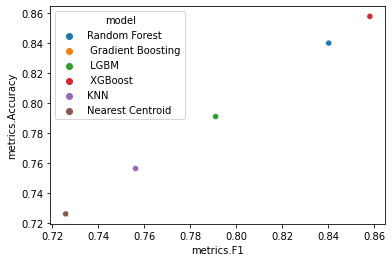

In [ ]:
import seaborn as sns

metrics = [
           {"model":"Random Forest","metrics":rf_metrics},
           {"model":" Gradient Boosting","metrics":gb_metrics},
           {"model":" LGBM","metrics":lgbm_metrics},
           {"model":" XGBoost","metrics":xgb_metrics},
           {"model":"KNN","metrics":knn_metrics},
           {"model":"Nearest Centroid","metrics":nc_metrics},
]
metrics_chart = pd.json_normalize(metrics)
sns.scatterplot(data=metrics_chart, x="metrics.F1", y="metrics.Accuracy", hue="model", legend="auto")

Como se puede observar, los modelos que mejor funcionan, sin optimizar los hiperparámetros y con el preprocesamiento estblacidos en el punto anterior, son los ensemble. En particular Random Forest y XGBoost destacan sobre los demás. 

## Hyperparameter tunning

Una vez estudiados algunos de los algoritmos de clasificación más representativos, se pretende encontrar una serie de hiperparámetros que mejoren la precisión del algoritmo. Para ello, podemos utilizar muchos métodos y librerías como [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) o [Hyperopt](https://hyperopt.github.io/hyperopt/), pero en este caso se va a emplear la librería [Nevergrad](https://facebookresearch.github.io/nevergrad/)
y se va a utilizar el algoritmo XGBoost Classifier.

In [ ]:
def train(max_depth,learning_rate,n_estimators,subsample,X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val):
    clf = xgb.XGBClassifier(random_state=42, max_depth=max_depth, 
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        subsample=subsample, eval_metric=f1_score,n_jobs = -1,
                        tree_method = "hist", single_precision_histogram=True)
    clf.fit(X_train, y_train)
    score = f1_score(y_val, clf.predict(X_val), average='weighted')
    print(score)
    return 1-score

max_depth = ng.p.TransitionChoice(range(15,300,10))
learning_rate = ng.p.Scalar(lower=0.04, upper=0.15)
n_estimators = ng.p.Choice(range(50,300,50))
subsample = ng.p.Scalar(lower=0.3,upper = 1.0)

params = ng.p.Instrumentation(max_depth,learning_rate,
                              n_estimators,subsample)
optimizer = ng.optimizers.TwoPointsDE(parametrization=params, budget=400)
best = optimizer.minimize(train, batch_mode=False)
print("MEJOR:",best.value)

Se imprime la mejor combinación de hiperparámetros:

In [ ]:
best.value

## Confusion Matrixes

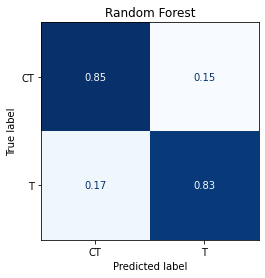

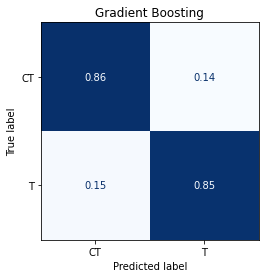

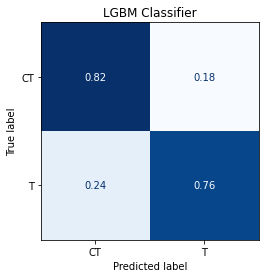

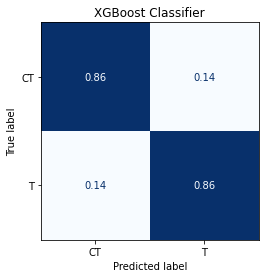

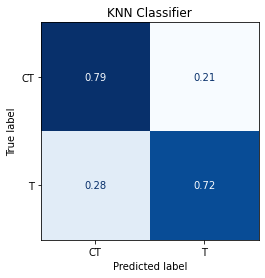

In [ ]:
preds = [rf_pred,gb_pred,lgbm_pred,xgbc_pred,knn_pred,nc_pred]
clsf = ['Random Forest', 'Gradient Boosting', 'LGBM Classifier', 'XGBoost Classifier' ,'KNN Classifier', 'Nearest Centroid Classifier']

for i in range(0,5):
    tmp = ConfusionMatrixDisplay.from_predictions(y_val, preds[i], cmap=plt.cm.Blues, 
                                        normalize='true', colorbar=False)
    tmp.ax_.set_title(clsf[i])
    print(tmp)

# Test data prediction

In [ ]:
ids = test_data.iloc[:,:1]

X_test = test_data.iloc[0:,1:]

drop_low_mean_std_columns(X_test)
X_test = column_transformer.transform(X_test)
X_test = sc.transform(X_test)

pred = xgbc.predict(X_test)

df = pd.DataFrame(pred, columns=['round_winner'])
df = ids.join(df)

df.to_csv('predictions.csv', index=False)
df

ct_weapon_bizon 		Media: 0.0 		Desviacion: 0.0
t_weapon_bizon 		Media: 2.0423168041826647e-05 		Desviacion: 0.004519199933818697
t_weapon_elite 		Media: 0.001919777795931705 		Desviacion: 0.04377363798703585
ct_weapon_g3sg1 		Media: 0.0 		Desviacion: 0.0
t_weapon_g3sg1 		Media: 0.0007760803855894127 		Desviacion: 0.03614563786859483
ct_weapon_m249 		Media: 0.0 		Desviacion: 0.0
t_weapon_m249 		Media: 0.0 		Desviacion: 0.0
t_weapon_mag7 		Media: 4.084633608365329e-05 		Desviacion: 0.006391048572420245
ct_weapon_mp5sd 		Media: 0.0014500449309696921 		Desviacion: 0.038052225596436604
ct_weapon_mp7 		Media: 0.0018789314598480517 		Desviacion: 0.044239504059757524
t_weapon_mp7 		Media: 0.002205702148517278 		Desviacion: 0.04777631543092224
ct_weapon_negev 		Media: 0.0 		Desviacion: 0.0
t_weapon_negev 		Media: 0.0 		Desviacion: 0.0
ct_weapon_nova 		Media: 0.0009598888979658525 		Desviacion: 0.030967516801040675
t_weapon_nova 		Media: 0.00010211584020913325 		Desviacion: 0.01010482547711413
c

,id,round_winner
0,6548,CT
1,79093,T
2,103345,T
3,17113,CT
4,108774,T
...,...,...
48959,122127,T
48960,93115,CT
48961,71219,T
48962,74073,CT


---

Created by **Roberto Mancebo Martín**

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">